#The Impact of Socio-Economic and Family Factors on Children's Mental Health in the U.S.
----
    This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

This project conducts a comprehensive analysis of children's well-being in the United States, exploring the intricate relationships between adverse childhood experiences (ACEs), family dynamics, and broader socio-economic factors at the state level.

**Data Sources:**

- ``National Survey of Children’s Health (NSCH) 2023:`` Provides detailed micro-data on individual children's health, family environment, and adverse experiences.

- ``American Community Survey (ACS) 2023 5-Year Estimates:`` Provides macro-data on socio-economic indicators for each state, accessed via the Census Bureau API.

**Methodology:**

The analysis is divided into two main parts:

- Part 1 (Micro-Level Analysis): Explores the relationships within the NSCH dataset, focusing on how ACEs and family protective factors correlate with children's mental health outcomes.

- Part 2 (Macro-Level Analysis): Merges aggregated NSCH data with ACS state-level data to investigate how the surrounding socio-economic environment is associated with children's well-being.

---

#Installing libraries and additional settings

In [ ]:
import requests
import pandas as pd
import duckdb
import io

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import userdata
from scipy.stats import pearsonr, spearmanr

In [ ]:
sns.set_theme(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
API_KEY = userdata.get('CENSUS_API_KEY')

---

#**PART 1:** Explores the relationships within the NSCH dataset, focusing on how ACEs and family protective factors correlate with children's mental health outcomes

- **Study 1.1: The impact of adverse childhood experiences (ACEs).**
  - Question: How is the number of adverse childhood experiences (ACEs) associated with diagnosed depression, anxiety, and conduct disorders?

| **Variable Name** | **Description** | **Source** |
|-------------------|-----------------|------------|
| **ACE1, ACE3–ACE9** | A series of questions about adverse experiences, such as economic hardship, parental separation, violence, etc. Used to create the `ace_score`. | NSCH |
| **K2Q35A**         | "Was child ever told they had depression?" Used to create the `depression_binary` variable. | NSCH |
| **K2Q34A**         | "Was child ever told they had a behavioral or conduct problem?" Used to create the `behavior_binary` variable. | NSCH |
| **SC_SEX**         | The sex of the child. Used for grouping in the gender analysis. | NSCH |

- **Study 1.2: The role of family routines and support.**
  - Question: Is there a relationship between a child’s resilience to stress and family factors such as home evenings and closeness with parents?

| **Variable Name** | **Description** | **Source** |
|-------------------|-----------------|------------|
| **K10Q40_R**       | "How well does this child stay calm and in control when faced with a challenge?" Used as the `resilience` variable. | NSCH |
| **K8Q21**          | "How well can you and this child share ideas or talk about things that really matter?" Used as the `communication` variable. | NSCH |


---

##PROJECT SETUP AND INITIAL DATA LOADING

**GOAL of this part:**

 - Load the NSCH 2023 Topical dataset, perform an initial inspection, and understand its structure.

**DATASET:**
- 2023 National Survey of Children’s Health (NSCH) - Topical File

In [ ]:
file_path = '/content/drive/MyDrive/API_work/nsch_2023e_topical.sas7bdat'

df = pd.read_sas(file_path)

print(f"Shape of the dataset (rows, columns): {df.shape}")

Shape of the dataset (rows, columns): (55162, 456)


In [ ]:
print("\n=== First 5 Rows (df.head()) ===")
display(df.head())

print("\n=== Dataframe Info (df.info()) ===")
df.info(100)

print("\n=== Descriptive Statistics (df.describe()) ===")
display(df.describe())

print("\n=== Checking for Missing Values (per column) ===")
missing_values = df.isnull().sum()
result = missing_values[missing_values > 0].sort_values(ascending=False)
display(result)


=== First 5 Rows (df.head()) ===


,HEIGHT,FIPSST,STRATUM,HHID,FORMTYPE,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,BIRTH_MO,BIRTH_YR,K6Q41R_STILL,K6Q42R_NEVER,K6Q43R_NEVER,K6Q13A,K6Q13B,K6Q14A,K6Q14B,EYECARE1,EYECARE2,EYECARE3,EYECARE4,K4Q30_R_1,K4Q30_R_2,K4Q30_R_3,DENTALSERV1,DENTALSERV2,DENTALSERV3,DENTALSERV4,DENTALSERV5,DENTALSERV6,DENTALSERV7,K4Q28X01,K4Q28X02,K4Q28X03,K4Q28X_EAR,K4Q28X04,K4Q28X05,SESPLANYR,SESPLANMO,K4Q37,SPCSERVMO,LIVEUSA_YR,LIVEUSA_MO,K11Q43R,PLACESLIVED,A1_AGE,A2_AGE,HHCOUNT,FAMCOUNT,BREATHING,SWALLOWING,STOMACH,PHYSICALPAIN,HANDS,COORDINATION,TOOTHACHES,GUMBLEED,CAVITIES,MEMORYCOND,WALKSTAIRS,DRESSING,ERRANDALONE,K2Q43B,BLINDNESS,ALLERGIES,ALLERGIES_CURR,K2Q40A,K2Q40B,AUTOIMMUNE,K2Q61A,DIABETES,DIABETES_CURR,K2Q42A,K2Q42B,HEART,HEART_BORN,HEART_CURR,HEADACHE,HEADACHE_CURR,K2Q38A,K2Q38B,K2Q33A,K2Q33B,K2Q32A,K2Q32B,DOWNSYN,BLOOD,SICKLECELL,THALASSEMIA,HEMOPHILIA,BLOOD_OTHER,BLOOD_SCREEN,CYSTFIB,CYSTFIB_SCREEN,FASD,K2Q34A,K2Q34B,K2Q36A,K2Q36B,K2Q60A,K2Q60B,K2Q37A,K2Q37B,K2Q30A,K2Q30B,K2Q35A,K2Q35B,AUTISMMED,AUTISMTREAT,K2Q31A,K2Q31B,K2Q31D,ADDTREAT,CONCUSSION,SEEKCARE,CONFIRMINJURY,K2Q05,K6Q40,S4Q01,DOCPRIVATE,OVERWEIGHT,K6Q10,K6Q12,ENGAGE_FAST,ENGAGE_INTEREST,ENGAGE_PICKY,ENGAGE_BINGE,ENGAGE_PURG,ENGAGE_PILLS,ENGAGE_EXERCISE,ENGAGE_NOEAT,K4Q01,USUALGO,USUALSICK,VISIONSCREENOTHER,VISIONEXAMREC,EYEDOCTOR,K4Q23,K4Q27,NOTELIG,AVAILABLE,APPOINTMENT,TRANSPORTCC,NOTOPEN,ISSUECOST,HOSPITALSTAY,K6Q15,SESCURRSVC,K4Q36,K4Q38,K5Q10,DECISIONS_R,K5Q21,TREATCHILD,TREATADULT,MEDHISTORY,WRITEPLAN,RECEIVECOPY,HEALTHKNOW,KEEPINSADULT,CURRCOV,K12Q03,K12Q04,K12Q12,TRICARE,K11Q03R,HCCOVOTH,K3Q25,STOPWORK,CUTHOURS,AVOIDCHG,ONEWORD,TWOWORDS,THREEWORDS,ASKQUESTION,ASKQUESTION2,TELLSTORY,UNDERSTAND,DIRECTIONS,POINT,DIRECTIONS2,UNDERSTAND2,REPEATED,K7Q30,K7Q31,K7Q32,K7Q37,K7Q38,BORNUSA,K8Q35,K6Q27,K9Q40,K9Q41,VAPE,K11Q60,K11Q61,K11Q62,EBTCARDS,S9Q34,SSI,SSIDISABILITY,K10Q11,K10Q12,K10Q13,K10Q14,K10Q20,K10Q22,K10Q23,K9Q96,ACE3,ACE4,ACE5,ACE6,ACE7,ACE8,ACE9,ACE10,ACE11,VIDEOPHONE,A1_DEPLSTAT,A2_DEPLSTAT,ALLERGIES_DESC,K2Q40C,AUTOIMMUNE_DESC,CERPALS_DESC,DIABETES_DESC,K2Q42C,HEART_DESC,HEADACHE_DESC,K2Q38C,K2Q33C,K2Q32C,BLOOD_DESC,K2Q34C,K2Q36C,K2Q60C,K2Q37C,K2Q30C,K2Q35C,K2Q31C,ENGAGECONCERN,BODYIMAGE,BOUNCEABALL,DRAWACIRCLE,DRAWAFACE,DRAWAPERSON,A1_SEX,A1_BORN,A1_EMPLOYED_R,A1_GRADE,A1_MARITAL,A1_RELATION,A2_SEX,A2_BORN,A2_EMPLOYED_R,A2_GRADE,A2_MARITAL,A2_RELATION,A1_ACTIVE,A2_ACTIVE,A1_PHYSHEALTH,A1_MENTHEALTH,A2_PHYSHEALTH,A2_MENTHEALTH,K2Q01,K2Q01_D,K5Q40,K5Q41,K5Q42,K5Q43,K5Q44,DISCUSSOPT,RAISECONC,BESTFORCHILD,K3Q20,K3Q22,K3Q21B,K6Q70_R,K6Q73_R,K6Q71_R,K6Q72_R,K7Q84_R,K7Q85_R,K7Q82_R,K7Q83_R,K7Q70_R,BULLIED_R,BULLY,RECOGBEGIN,SAMESOUND,CLEAREXP,WRITENAME,FOCUSON,READONEDIGIT,SIMPLEADDITION,GROUPOFOBJECTS,NAMEEMOTIONS,STARTNEWACT,TEMPER_R,PLAYWELL,DISTRACTED,HURTSAD,CALMDOWN_R,WAITFORTURN,HARDWORK,SHARETOYS,RECOGABC,TALKABOUT,WKTOSOLVE,STRENGTHS,HOPEFUL,K10Q30,K10Q31,K10Q40_R,GOFORHELP,K10Q41_R,K8Q31,K8Q32,K8Q34,HOWMUCH,ATHOMEHC,ARRANGEHC,K7Q02R_R,K7Q04R_R,PHYSACTIV,HOURSLEEP05,HOURSLEEP,OUTDOORSWKDAY,OUTDOORSWKEND,SCREENTIME,K6Q60_R,K6Q61_R,K8Q11,FOODSIT,EVALFASD,RECEVALFASD,POSCHOICE,GAINSKILLS,CHANGEAGE,MISSMORTGAGE,EVERHOMELESS,K2Q35D,HCABILITY,HCEXTENT,K4Q20R,DOCROOM,WGTCONC,GOWHENSICK,DENTISTVISIT,K4Q22_R,TREATNEED,K4Q24_R,K4Q26,C4Q04,HOSPITALER,K4Q04_R,K5Q11,K5Q20_R,K5Q22,K5Q30,K5Q32,K5Q31_R,K8Q21,K8Q30,COUNTTO_R,K7Q33,BEDTIME,K3Q04_R,ACE1,MAKEFRIEND,STARTSCHOOL,SUGARDRINK,VEGETABLES,FRUIT,PLANNEEDS_R,RHYMEWORD_R,GRADES,HOMEEVIC,YEAR,CBSAFP_YN,METRO_YN,MPC_YN,TOTAGE_0_5,TOTAGE_6_11,TOTAGE_12_17,TOTCSHCN,TOTNONSHCN,SC_CSHCN,SC_RACE_R,SC_HISPANIC_R,SC_ENGLISH,SC_K2Q10,SC_K2Q11,SC_K2Q12,SC_K2Q13,SC_K2Q14,SC_K2Q15,SC_K2Q16,SC_K2Q17,SC_K2Q18,SC_K2Q19,SC_K2Q20,SC_K2Q21,SC_K2Q22,SC_K2Q23,SC_AGE_LT4,SC_AGE_LT6,SC_AGE_LT9,SC_AGE_LT10,AGEPOS4,TENURE_IF,TOTMALE,TOTFEMALE,SC_RACE_R_IF,SC_RACER,SC_HISPANIC_R_IF,SC_SEX_IF,BIRTHWT_OZ_S,BREASTFEDEND_DAY_S,BREASTFEDEND_WK_S,BREASTFEDEND_MO_S,FRSTFORMULA_DAY_S,FRSTFORMULA_WK_S,FRSTFORMULA_MO_S,FRSTSO


=== Dataframe Info (df.info()) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55162 entries, 0 to 55161
Data columns (total 456 columns):
 #    Column              Dtype  
---   ------              -----  
 0    HEIGHT              float64
 1    FIPSST              object 
 2    STRATUM             object 
 3    HHID                object 
 4    FORMTYPE            object 
 5    TOTKIDS_R           float64
 6    TENURE              float64
 7    HHLANGUAGE          float64
 8    SC_AGE_YEARS        float64
 9    SC_SEX              float64
 10   K2Q35A_1_YEARS      float64
 11   BIRTH_MO            float64
 12   BIRTH_YR            float64
 13   K6Q41R_STILL        float64
 14   K6Q42R_NEVER        float64
 15   K6Q43R_NEVER        float64
 16   K6Q13A              float64
 17   K6Q13B              float64
 18   K6Q14A              float64
 19   K6Q14B              float64
 20   EYECARE1            float64
 21   EYECARE2            float64
 22   EYECARE3            float64
 23 

,HEIGHT,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,BIRTH_MO,BIRTH_YR,K6Q41R_STILL,K6Q42R_NEVER,K6Q43R_NEVER,K6Q13A,K6Q13B,K6Q14A,K6Q14B,EYECARE1,EYECARE2,EYECARE3,EYECARE4,K4Q30_R_1,K4Q30_R_2,K4Q30_R_3,DENTALSERV1,DENTALSERV2,DENTALSERV3,DENTALSERV4,DENTALSERV5,DENTALSERV6,DENTALSERV7,K4Q28X01,K4Q28X02,K4Q28X03,K4Q28X_EAR,K4Q28X04,K4Q28X05,SESPLANYR,SESPLANMO,K4Q37,SPCSERVMO,LIVEUSA_YR,LIVEUSA_MO,K11Q43R,PLACESLIVED,A1_AGE,A2_AGE,HHCOUNT,FAMCOUNT,BREATHING,SWALLOWING,STOMACH,PHYSICALPAIN,HANDS,COORDINATION,TOOTHACHES,GUMBLEED,CAVITIES,MEMORYCOND,WALKSTAIRS,DRESSING,ERRANDALONE,K2Q43B,BLINDNESS,ALLERGIES,ALLERGIES_CURR,K2Q40A,K2Q40B,AUTOIMMUNE,K2Q61A,DIABETES,DIABETES_CURR,K2Q42A,K2Q42B,HEART,HEART_BORN,HEART_CURR,HEADACHE,HEADACHE_CURR,K2Q38A,K2Q38B,K2Q33A,K2Q33B,K2Q32A,K2Q32B,DOWNSYN,BLOOD,SICKLECELL,THALASSEMIA,HEMOPHILIA,BLOOD_OTHER,BLOOD_SCREEN,CYSTFIB,CYSTFIB_SCREEN,FASD,K2Q34A,K2Q34B,K2Q36A,K2Q36B,K2Q60A,K2Q60B,K2Q37A,K2Q37B,K2Q30A,K2Q30B,K2Q35A,K2Q35B,AUTISMMED,AUTISMTREAT,K2Q31A,K2Q31B,K2Q31D,ADDTREAT,CONCUSSION,SEEKCARE,CONFIRMINJURY,K2Q05,K6Q40,S4Q01,DOCPRIVATE,OVERWEIGHT,K6Q10,K6Q12,ENGAGE_FAST,ENGAGE_INTEREST,ENGAGE_PICKY,ENGAGE_BINGE,ENGAGE_PURG,ENGAGE_PILLS,ENGAGE_EXERCISE,ENGAGE_NOEAT,K4Q01,USUALGO,USUALSICK,VISIONSCREENOTHER,VISIONEXAMREC,EYEDOCTOR,K4Q23,K4Q27,NOTELIG,AVAILABLE,APPOINTMENT,TRANSPORTCC,NOTOPEN,ISSUECOST,HOSPITALSTAY,K6Q15,SESCURRSVC,K4Q36,K4Q38,K5Q10,DECISIONS_R,K5Q21,TREATCHILD,TREATADULT,MEDHISTORY,WRITEPLAN,RECEIVECOPY,HEALTHKNOW,KEEPINSADULT,CURRCOV,K12Q03,K12Q04,K12Q12,TRICARE,K11Q03R,HCCOVOTH,K3Q25,STOPWORK,CUTHOURS,AVOIDCHG,ONEWORD,TWOWORDS,THREEWORDS,ASKQUESTION,ASKQUESTION2,TELLSTORY,UNDERSTAND,DIRECTIONS,POINT,DIRECTIONS2,UNDERSTAND2,REPEATED,K7Q30,K7Q31,K7Q32,K7Q37,K7Q38,BORNUSA,K8Q35,K6Q27,K9Q40,K9Q41,VAPE,K11Q60,K11Q61,K11Q62,EBTCARDS,S9Q34,SSI,SSIDISABILITY,K10Q11,K10Q12,K10Q13,K10Q14,K10Q20,K10Q22,K10Q23,K9Q96,ACE3,ACE4,ACE5,ACE6,ACE7,ACE8,ACE9,ACE10,ACE11,VIDEOPHONE,A1_DEPLSTAT,A2_DEPLSTAT,ALLERGIES_DESC,K2Q40C,AUTOIMMUNE_DESC,CERPALS_DESC,DIABETES_DESC,K2Q42C,HEART_DESC,HEADACHE_DESC,K2Q38C,K2Q33C,K2Q32C,BLOOD_DESC,K2Q34C,K2Q36C,K2Q60C,K2Q37C,K2Q30C,K2Q35C,K2Q31C,ENGAGECONCERN,BODYIMAGE,BOUNCEABALL,DRAWACIRCLE,DRAWAFACE,DRAWAPERSON,A1_SEX,A1_BORN,A1_EMPLOYED_R,A1_GRADE,A1_MARITAL,A1_RELATION,A2_SEX,A2_BORN,A2_EMPLOYED_R,A2_GRADE,A2_MARITAL,A2_RELATION,A1_ACTIVE,A2_ACTIVE,A1_PHYSHEALTH,A1_MENTHEALTH,A2_PHYSHEALTH,A2_MENTHEALTH,K2Q01,K2Q01_D,K5Q40,K5Q41,K5Q42,K5Q43,K5Q44,DISCUSSOPT,RAISECONC,BESTFORCHILD,K3Q20,K3Q22,K3Q21B,K6Q70_R,K6Q73_R,K6Q71_R,K6Q72_R,K7Q84_R,K7Q85_R,K7Q82_R,K7Q83_R,K7Q70_R,BULLIED_R,BULLY,RECOGBEGIN,SAMESOUND,CLEAREXP,WRITENAME,FOCUSON,READONEDIGIT,SIMPLEADDITION,GROUPOFOBJECTS,NAMEEMOTIONS,STARTNEWACT,TEMPER_R,PLAYWELL,DISTRACTED,HURTSAD,CALMDOWN_R,WAITFORTURN,HARDWORK,SHARETOYS,RECOGABC,TALKABOUT,WKTOSOLVE,STRENGTHS,HOPEFUL,K10Q30,K10Q31,K10Q40_R,GOFORHELP,K10Q41_R,K8Q31,K8Q32,K8Q34,HOWMUCH,ATHOMEHC,ARRANGEHC,K7Q02R_R,K7Q04R_R,PHYSACTIV,HOURSLEEP05,HOURSLEEP,OUTDOORSWKDAY,OUTDOORSWKEND,SCREENTIME,K6Q60_R,K6Q61_R,K8Q11,FOODSIT,EVALFASD,RECEVALFASD,POSCHOICE,GAINSKILLS,CHANGEAGE,MISSMORTGAGE,EVERHOMELESS,K2Q35D,HCABILITY,HCEXTENT,K4Q20R,DOCROOM,WGTCONC,GOWHENSICK,DENTISTVISIT,K4Q22_R,TREATNEED,K4Q24_R,K4Q26,C4Q04,HOSPITALER,K4Q04_R,K5Q11,K5Q20_R,K5Q22,K5Q30,K5Q32,K5Q31_R,K8Q21,K8Q30,COUNTTO_R,K7Q33,BEDTIME,K3Q04_R,ACE1,MAKEFRIEND,STARTSCHOOL,SUGARDRINK,VEGETABLES,FRUIT,PLANNEEDS_R,RHYMEWORD_R,GRADES,HOMEEVIC,YEAR,CBSAFP_YN,METRO_YN,MPC_YN,TOTAGE_0_5,TOTAGE_6_11,TOTAGE_12_17,TOTCSHCN,TOTNONSHCN,SC_CSHCN,SC_RACE_R,SC_HISPANIC_R,SC_ENGLISH,SC_K2Q10,SC_K2Q11,SC_K2Q12,SC_K2Q13,SC_K2Q14,SC_K2Q15,SC_K2Q16,SC_K2Q17,SC_K2Q18,SC_K2Q19,SC_K2Q20,SC_K2Q21,SC_K2Q22,SC_K2Q23,SC_AGE_LT4,SC_AGE_LT6,SC_AGE_LT9,SC_AGE_LT10,AGEPOS4,TENURE_IF,TOTMALE,TOTFEMALE,SC_RACE_R_IF,SC_RACER,SC_HISPANIC_R_IF,SC_SEX_IF,BIRTHWT_OZ_S,BREASTFEDEND_DAY_S,BREASTFEDEND_WK_S,BREASTFEDEND_MO_S,FRSTFORMULA_DAY_S,FRSTFORMULA_WK_S,FRSTFORMULA_MO_S,FRSTSOLIDS_DAY_S,FRSTSOLIDS_WK_S,FR


=== Checking for Missing Values (per column) ===


,0
CYSTFIB_SCREEN,55134
DIABETES_DESC,55132
DIABETES_CURR,55119
K2Q38C,55046
LIVEUSA_MO,55040
CERPALS_DESC,55024
K2Q38B,55016
BREASTFEDEND_DAY_S,54954
HEMOPHILIA,54923
SICKLECELL,54917


- **Data types:** We see columns of type ``float64`` (*numbers*) and ``object``. Notice the ``b'`` prefix in some of the values (for example, ``b'06'`` in the ``FIPSST`` column). This means that pandas read them as *bytes*, not as regular *text strings*. This is a common occurrence when working with ``SAS`` files, and we can easily fix this.

- **Numeric codes:** Almost all of the data is represented as *numbers* (``1.0``, ``2.0``, ``3.0``, etc.). These are codes that we will need to decipher to make the analysis understandable (for example, convert ``SC_SEX`` ``1.0`` to ``'Male'`` and ``2.0`` to ``'Female'``).

- **Huge number of missing values (``NaN``):** The ``missing_values`` output shows that there are *missing values* in almost every column. This is completely normal for *survey data*. Many questions are only asked to certain groups of respondents (for example, questions about pregnancy are not asked to men). Our task is to correctly handle these gaps for the variables we are interested in.

---

##DATA CLEANING, SUBSETTING, AND FEATURE ENGINEERING

**GOAL of this part:**
1. Select only the variables needed for our first research question.
2. Clean the data (e.g., decode byte strings).
3. Engineer a new feature: the cumulative ACE Score.

###1. DEFINE VARIABLES OF INTEREST
**Subsetting:** A smaller, more manageable DataFrame (``df_subset``) was created, containing only the variables required for our initial hypotheses.

In [ ]:
variables_of_interest = [
    'ACE1', 'ACE3', 'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9',
    'K2Q35A',
    'K2Q35B',
    'K2Q34A',
    'SC_AGE_YEARS', 'SC_SEX', 'FIPSST'
]

df_subset = df[variables_of_interest].copy()

print(f"Subset DataFrame created with shape: {df_subset.shape}")
print(df_subset.columns.tolist())

Subset DataFrame created with shape: (55162, 14)
['ACE1', 'ACE3', 'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'K2Q35A', 'K2Q35B', 'K2Q34A', 'SC_AGE_YEARS', 'SC_SEX', 'FIPSST']


###2. CLEAN DATA
**Cleaning:** Column names were converted to lowercase, and byte-string data (a common artifact from SAS files) was decoded into standard text.

In [ ]:
df_subset.columns = df_subset.columns.str.lower()

df_subset['fipsst'] = df_subset['fipsst'].astype(str)

for col in df_subset.select_dtypes(include=['object']).columns:
    df_subset[col] = df_subset[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

display(df_subset.head())

,ace1,ace3,ace4,ace5,ace6,ace7,ace8,ace9,k2q35a,k2q35b,k2q34a,sc_age_years,sc_sex,fipsst
0,3.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,NaN,2.0,11.0,1.0,06
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,14.0,2.0,06
2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,17.0,2.0,06
3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,12.0,2.0,06
4,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,10.0,2.0,06


###3. FEATURE ENGINEERING: CREATE ACE SCORE
**Feature Engineering:** A crucial composite variable, ``ace_score``, was created by summing up the occurrences of 8 different adverse childhood experiences. This score serves as our primary measure of cumulative stress.

In [ ]:
ace_columns = [col for col in df_subset.columns if col.startswith('ace')]
print(f"\nFound the following ACE columns to create the score: {ace_columns}")

for col in ace_columns:
    df_subset[f'{col}_c'] = df_subset[col].apply(lambda x: 1 if x == 1.0 else 0)

cleaned_ace_columns = [f'{col}_c' for col in ace_columns]
df_subset['ace_score'] = df_subset[cleaned_ace_columns].sum(axis=1)



Found the following ACE columns to create the score: ['ace1', 'ace3', 'ace4', 'ace5', 'ace6', 'ace7', 'ace8', 'ace9']


###FINAL INSPECTION OF THE NEW DATAFRAME

In [ ]:
# print("\n=== Diagnostic check of 'fipsst' before final info ===")
# print(f"Data type of 'fipsst': {df_subset['fipsst'].dtype}")
# print("Is 'fipsst' all null? ", df_subset['fipsst'].isnull().all())
# print("Top 5 values of 'fipsst':")
# print(df_subset['fipsst'].head())


print("\n=== Final Subset DataFrame Info (df_subset.info()) ===")
df_subset.info()

print("\n=== Value Counts for 'ace_score' ===")
display(df_subset['ace_score'].value_counts().sort_index())

print("\n=== Head of DataFrame with new ACE score ===")
display(df_subset.head())



=== Final Subset DataFrame Info (df_subset.info()) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55162 entries, 0 to 55161
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ace1          54136 non-null  float64
 1   ace3          53127 non-null  float64
 2   ace4          53055 non-null  float64
 3   ace5          53003 non-null  float64
 4   ace6          52946 non-null  float64
 5   ace7          52998 non-null  float64
 6   ace8          52950 non-null  float64
 7   ace9          52952 non-null  float64
 8   k2q35a        54866 non-null  float64
 9   k2q35b        2114 non-null   float64
 10  k2q34a        55052 non-null  float64
 11  sc_age_years  55162 non-null  float64
 12  sc_sex        55162 non-null  float64
 13  fipsst        55162 non-null  object 
 14  ace1_c        55162 non-null  int64  
 15  ace3_c        55162 non-null  int64  
 16  ace4_c        55162 non-null  int64  
 17  ace5_c       

,count
ace_score,
0,13315
1,31615
2,6052
3,2086
4,1058
5,579
6,320
7,122
8,15



=== Head of DataFrame with new ACE score ===


,ace1,ace3,ace4,ace5,ace6,ace7,ace8,ace9,k2q35a,k2q35b,k2q34a,sc_age_years,sc_sex,fipsst,ace1_c,ace3_c,ace4_c,ace5_c,ace6_c,ace7_c,ace8_c,ace9_c,ace_score
0,3.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,NaN,2.0,11.0,1.0,06,0,1,0,1,1,0,0,0,3
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,14.0,2.0,06,0,0,0,0,0,0,0,0,0
2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,17.0,2.0,06,1,0,0,0,0,0,0,0,1
3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,12.0,2.0,06,1,0,0,0,0,0,0,0,1
4,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,10.0,2.0,06,1,0,0,0,0,0,0,0,1


---

##DATA RECODING FOR ANALYSIS

GOAL of this part:
1. Convert numeric codes for our key variables into human-readable labels.
2. This makes future analysis, visualizations, and interpretation much easier.


###1. DEFINE MAPPING DICTIONARIES

In [ ]:

# for 'Yes'/'No' questions like diagnoses. Typically 1='Yes', 2='No'.
yes_no_map = {
    1.0: 'Yes',
    2.0: 'No'
}

# for gender/sex. Typically 1='Male', 2='Female'.
sex_map = {
    1.0: 'Male',
    2.0: 'Female'
}


###2. RECODE DEPENDENT VARIABLES (MENTAL HEALTH)

In [ ]:
# create new columns with the suffix '_label' to hold the text values.

# recode Depression (k2q35a)
df_subset['depression_label'] = df_subset['k2q35a'].map(yes_no_map)

# Anxiety (k2q35b)
df_subset['anxiety_label'] = df_subset['k2q35b'].map(yes_no_map)

# Behavioral Problems (k2q34a)
df_subset['behavior_label'] = df_subset['k2q34a'].map(yes_no_map)


###RECODE CONTROL VARIABLES (DEMOGRAPHICS)

In [ ]:
# recode Sex (sc_sex)
df_subset['sex_label'] = df_subset['sc_sex'].map(sex_map)


###VERIFY THE RECODING

In [ ]:
print("\nDepression Diagnosis:")
display(df_subset['depression_label'].value_counts(dropna=False))

print("\nAnxiety Diagnosis:")
display(df_subset['anxiety_label'].value_counts(dropna=False))

print("\nBehavioral Problems Diagnosis:")
display(df_subset['behavior_label'].value_counts(dropna=False))

print("\nSex:")
display(df_subset['sex_label'].value_counts(dropna=False))


Depression Diagnosis:


,count
depression_label,
No,52736
Yes,2130
NaN,296



Anxiety Diagnosis:


,count
anxiety_label,
NaN,53048
Yes,2019
No,95



Behavioral Problems Diagnosis:


,count
behavior_label,
No,50524
Yes,4528
NaN,110



Sex:


,count
sex_label,
Male,28330
Female,26832


###FINAL DATAFRAME PREVIEW

In [ ]:
print("\n=== Head of DataFrame with new labeled columns ===")
display(df_subset[[
    'ace_score',
    'k2q35a', 'depression_label',
    'k2q35b', 'anxiety_label',
    'sc_sex', 'sex_label'
]].head())



=== Head of DataFrame with new labeled columns ===


,ace_score,k2q35a,depression_label,k2q35b,anxiety_label,sc_sex,sex_label
0,3,2.0,No,NaN,NaN,1.0,Male
1,0,2.0,No,NaN,NaN,2.0,Female
2,1,2.0,No,NaN,NaN,2.0,Female
3,1,2.0,No,NaN,NaN,2.0,Female
4,1,2.0,No,NaN,NaN,2.0,Female


---

##**Research Question 1.1: The Impact of ACEs**


  - **Hypothesis:** A higher number of Adverse Childhood Experiences (``ACEs``) is positively correlated with a higher prevalence of diagnosed depression and behavioral problems in children.

- **Variables Used:**

  - **Independent:** ``ace_score`` (Engineered from ``NSCH`` variables ``ACE1``, ``ACE3``-``ACE9``).

  - **Dependent:** ``depression_label``, ``behavior_label`` (From ``NSCH`` variables ``K2Q35A``, ``K2Q34A``).

  - **Control/Grouping:** ``sex_label`` (From ``NSCH`` variable ``SC_SEX``)

####ANALYSIS: ACE SCORE vs. DEPRESSION


=== Prevalence of Depression by ACE Score ===


/tmp/ipython-input-430575386.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=depression_by_ace.index, y=depression_by_ace['Yes'] * 100, palette="viridis")


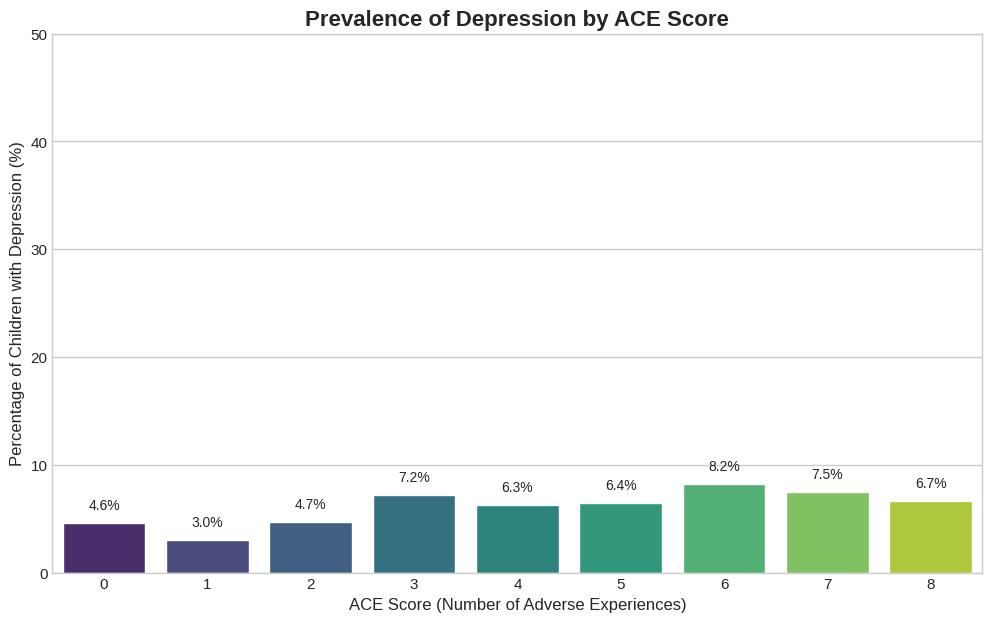

In [ ]:
# calculate the percentage of 'Yes' for depression within each ACE score group
# group by 'ace_score', then get the value counts for 'depression_label' and normalize to get percentages.
depression_by_ace = df_subset.groupby('ace_score')['depression_label'].value_counts(normalize=True).unstack()

# check if 'Yes' column exists after unstacking. If not, it means no 'Yes' answers for some groups.
if 'Yes' not in depression_by_ace.columns:
    depression_by_ace['Yes'] = 0

depression_by_ace = depression_by_ace.fillna(0)

print("\n=== Prevalence of Depression by ACE Score ===")

plt.figure(figsize=(12, 7))
sns.barplot(x=depression_by_ace.index, y=depression_by_ace['Yes'] * 100, palette="viridis")

plt.title('Prevalence of Depression by ACE Score', fontsize=16, fontweight='bold')
plt.xlabel('ACE Score (Number of Adverse Experiences)', fontsize=12)
plt.ylabel('Percentage of Children with Depression (%)', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 50)

for index, value in enumerate(depression_by_ace['Yes']):
    plt.text(index, value * 100 + 1, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()


In [ ]:

# create binary variable for Depress (1 for 'Yes', 0 for 'No')
df_subset.loc[:, 'depression_binary'] = df_subset['k2q35a'].apply(lambda x: 1 if x == 1.0 else 0)

# binary variable for Behavioral Probl
df_subset.loc[:, 'behavior_binary'] = df_subset['k2q34a'].apply(lambda x: 1 if x == 1.0 else 0)


In [ ]:
df_depression_corr = df_subset.dropna(subset=['k2q35a'])

# Spearman's corr
corr_dep, p_dep = spearmanr(df_depression_corr['ace_score'], df_depression_corr['depression_binary'])

print("\n=== Analysis: ACE Score vs. Depression ===")
print(f"Spearman's Correlation Coefficient (rho): {corr_dep:.4f}")
print(f"P-value: {p_dep:.4f}")


=== Analysis: ACE Score vs. Depression ===
Spearman's Correlation Coefficient (rho): 0.0112
P-value: 0.0084


####ANALYSIS: ACE SCORE vs. BEHAVIORAL PROBLEMS


=== Prevalence of Behavioral Problems by ACE Score ===


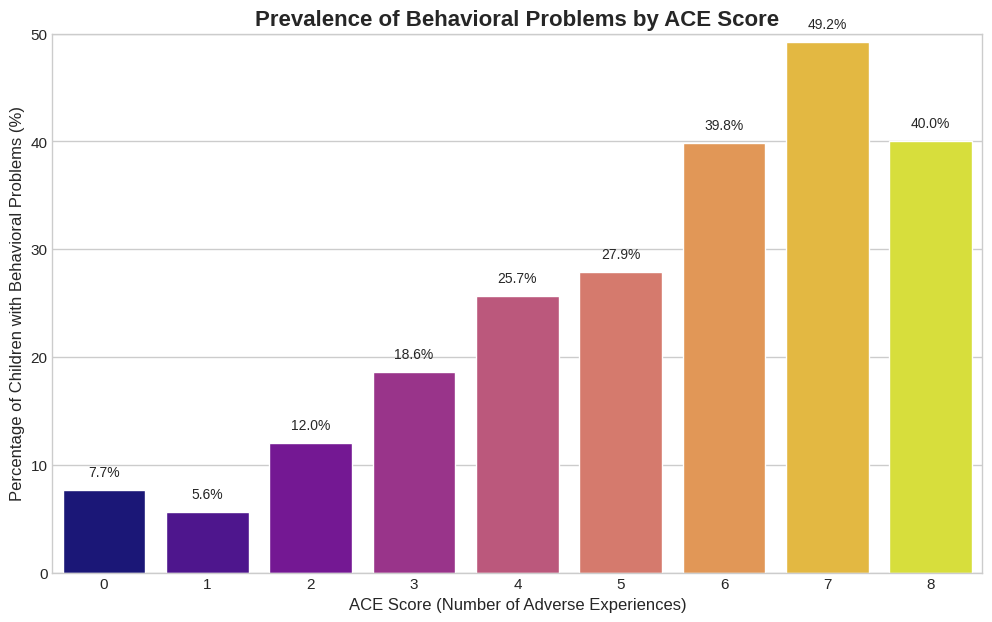

In [ ]:

behavior_by_ace = df_subset.groupby('ace_score')['behavior_label'].value_counts(normalize=True).unstack()
if 'Yes' not in behavior_by_ace.columns:
    behavior_by_ace['Yes'] = 0
behavior_by_ace = behavior_by_ace.fillna(0)

print("\n=== Prevalence of Behavioral Problems by ACE Score ===")

plt.figure(figsize=(12, 7))
sns.barplot(x=behavior_by_ace.index, y=behavior_by_ace['Yes'] * 100, hue=behavior_by_ace.index, palette="plasma", legend=False)

plt.title('Prevalence of Behavioral Problems by ACE Score', fontsize=16, fontweight='bold')
plt.xlabel('ACE Score (Number of Adverse Experiences)', fontsize=12)
plt.ylabel('Percentage of Children with Behavioral Problems (%)', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 50)

for index, value in enumerate(behavior_by_ace['Yes']):
    plt.text(index, value * 100 + 1, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()


In [ ]:
df_behavior_corr = df_subset.dropna(subset=['k2q34a'])

corr_beh, p_beh = spearmanr(df_behavior_corr['ace_score'], df_behavior_corr['behavior_binary'])

print("\n=== Analysis: ACE Score vs. Behavioral Problems ===")
print(f"Spearman's Correlation Coefficient (rho): {corr_beh:.4f}")
print(f"P-value: {p_beh:.4f}")


=== Analysis: ACE Score vs. Behavioral Problems ===
Spearman's Correlation Coefficient (rho): 0.1037
P-value: 0.0000


####DEEPER DIVE: GENDER DIFFERENCES


=== Trend of Depression by ACE Score and Sex ===


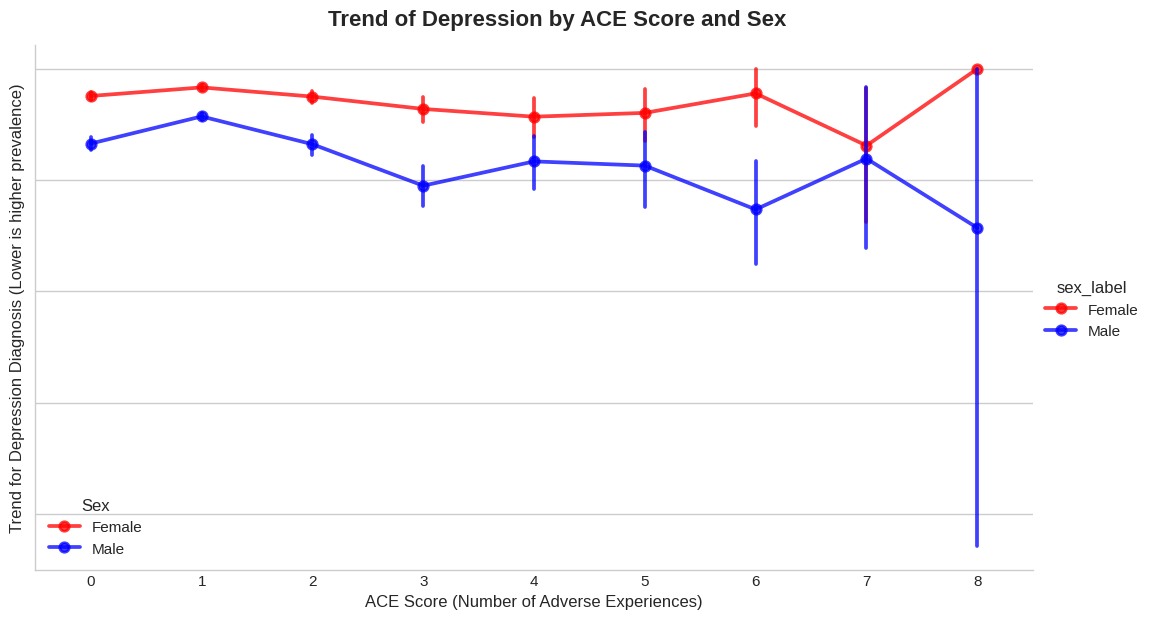

In [ ]:
# does the relationship between ACEs and depression differ by gender
print("\n=== Trend of Depression by ACE Score and Sex ===")

g = sns.catplot(
    data=df_subset,
    x='ace_score',
    y='k2q35a', # use the numeric version (1=Yes, 2=No) for calc
    hue='sex_label',
    kind='point',
    palette={'Male': 'blue', 'Female': 'red'},
    height=6,
    aspect=1.8,
    alpha=0.75
    #legend=False
)

g.ax.set_yticklabels([])
g.ax.set_ylabel('Trend for Depression Diagnosis (Lower is higher prevalence)')
g.ax.set_xlabel('ACE Score (Number of Adverse Experiences)', fontsize=12)
g.fig.suptitle('Trend of Depression by ACE Score and Sex', y=1.03, fontsize=16, fontweight='bold')
plt.legend(title='Sex')

plt.show()


###Analysis and Conclusions
- **Visual Analysis:** The bar plots clearly show a dose-response relationship: as the ``ace_score`` increases, the percentage of children with both depression and behavioral problems rises. The trend is particularly dramatic for behavioral problems. The point plot for gender differences suggests that females have a consistently higher prevalence of depression across all ``ACE`` score levels.

- **Statistical Analysis (*Spearman's Correlation*):**

  - **ACEs vs. Depression:** A statistically significant, but very weak, positive correlation was found (``rho = 0.0112, p < 0.05``). This confirms the visual trend is not random, but its magnitude is small.

  - **ACEs vs. Behavioral Problems:** A statistically significant and much stronger positive correlation was found (``rho = 0.1037, p < 0.001``). This quantitatively confirms that the link between ``ACEs`` and behavioral issues is substantially more pronounced than the link with depression.

- **Conclusion:** The hypothesis is **confirmed**. ACEs are a significant risk factor for both conditions, but their association with behavioral problems is markedly stronger.

---

##**Research Question 1.2: The Role of Protective Factors**

- Hypothesis (The Buffering Hypothesis): Positive family factors, such as good parent-child communication, can act as a "buffer," weakening the negative relationship between a high ``ACE`` score and the likelihood of depression.

- Variables Used:

  - Protective Factors: ``resilience`` (``K10Q40_R``), ``communication_label`` (``K8Q21``).

  - Interaction with: ``ace_score`` and ``depression_binary``.

GOAL of this part:
1. Add variables related to family resilience and support to our dataset.
2. Recode these variables into human-readable formats for analysis.
3. This will allow us to investigate if these factors can mitigate the negative impact of ACEs.

####1. DEFINE NEW VARIABLES OF INTEREST

In [ ]:
# select variables that represent family support, routines, and child's resilience.
protective_factors_vars = {
    'K6Q60_R': 'family_meals',       # how often family eats together
    'K10Q40_R': 'resilience',         # how well child handles challenges
    'K8Q21': 'communication'         # how well child/parents share ideas
}

for original_name, new_name in protective_factors_vars.items():
    df_subset[new_name] = df[original_name]
    print(f"Variable '{original_name}' added as '{new_name}'.")


Variable 'K6Q60_R' added as 'family_meals'.
Variable 'K10Q40_R' added as 'resilience'.
Variable 'K8Q21' added as 'communication'.


####2. RECODE PROTECTIVE FACTOR VARIABLES

In [ ]:

# recode Resilience (K10Q40_R)
# based on codebook: 1=Very well, 2=Somewhat well, 3=A little, 4=Not at all
resilience_map = {
    1.0: 'Very well',
    2.0: 'Somewhat well',
    3.0: 'A little/Not at all',
    4.0: 'A little/Not at all'
}
df_subset['resilience_label'] = df_subset['resilience'].map(resilience_map)

# Family Meals (K6Q60_R)
# on codebook: 1=0 days, 2=1-3 days, 3=4-6 days, 4=7 days
meals_map = {
    1.0: '0 days',
    2.0: '1-3 days',
    3.0: '4-6 days',
    4.0: 'Every day'
}
df_subset['family_meals_label'] = df_subset['family_meals'].map(meals_map)

# Communication (K8Q21)
# on codebook: 1=Always, 2=Usually, 3=Sometimes, 4=Never
communication_map = {
    1.0: 'Always/Usually',
    2.0: 'Always/Usually',
    3.0: 'Sometimes/Never',
    4.0: 'Sometimes/Never'
}
df_subset['communication_label'] = df_subset['communication'].map(communication_map)


####3. VERIFY THE RECODING

In [ ]:

print("\n=== Value Counts for Recoded Protective Factors ===")

print("\nChild's Resilience:")
print(df_subset['resilience_label'].value_counts(dropna=False))

print("\nFrequency of Family Meals:")
print(df_subset['family_meals_label'].value_counts(dropna=False))

print("\nParent-Child Communication:")
print(df_subset['communication_label'].value_counts(dropna=False))



=== Value Counts for Recoded Protective Factors ===

Child's Resilience:
resilience_label
Very well              37110
Somewhat well          14400
A little/Not at all     1978
NaN                     1674
Name: count, dtype: int64

Frequency of Family Meals:
family_meals_label
NaN          34069
Every day    10786
1-3 days      5648
4-6 days      3676
0 days         983
Name: count, dtype: int64

Parent-Child Communication:
communication_label
Always/Usually     31328
NaN                22095
Sometimes/Never     1739
Name: count, dtype: int64


####4. FINAL DATAFRAME PREVIEW

In [ ]:
print("\n=== DataFrame with new protective factor columns ===\n")
print(df_subset[[
    'ace_score',
    'resilience_label',
    'family_meals_label',
    'communication_label'
]].head())



=== DataFrame with new protective factor columns ===

   ace_score     resilience_label family_meals_label communication_label
0          3  A little/Not at all                NaN      Always/Usually
1          0            Very well                NaN      Always/Usually
2          1            Very well                NaN      Always/Usually
3          1            Very well                NaN      Always/Usually
4          1  A little/Not at all                NaN      Always/Usually


###VISUALIZING THE IMPACT OF PROTECTIVE FACTORS

GOAL of this part:
1. Analyze how protective factors like resilience and communication correlate with ACE scores.
2. Investigate the "buffering hypothesis": Can good family communication mitigate the negative effect of ACEs on depression?

####1. ANALYSIS: RESILIENCE vs. ACE SCORE

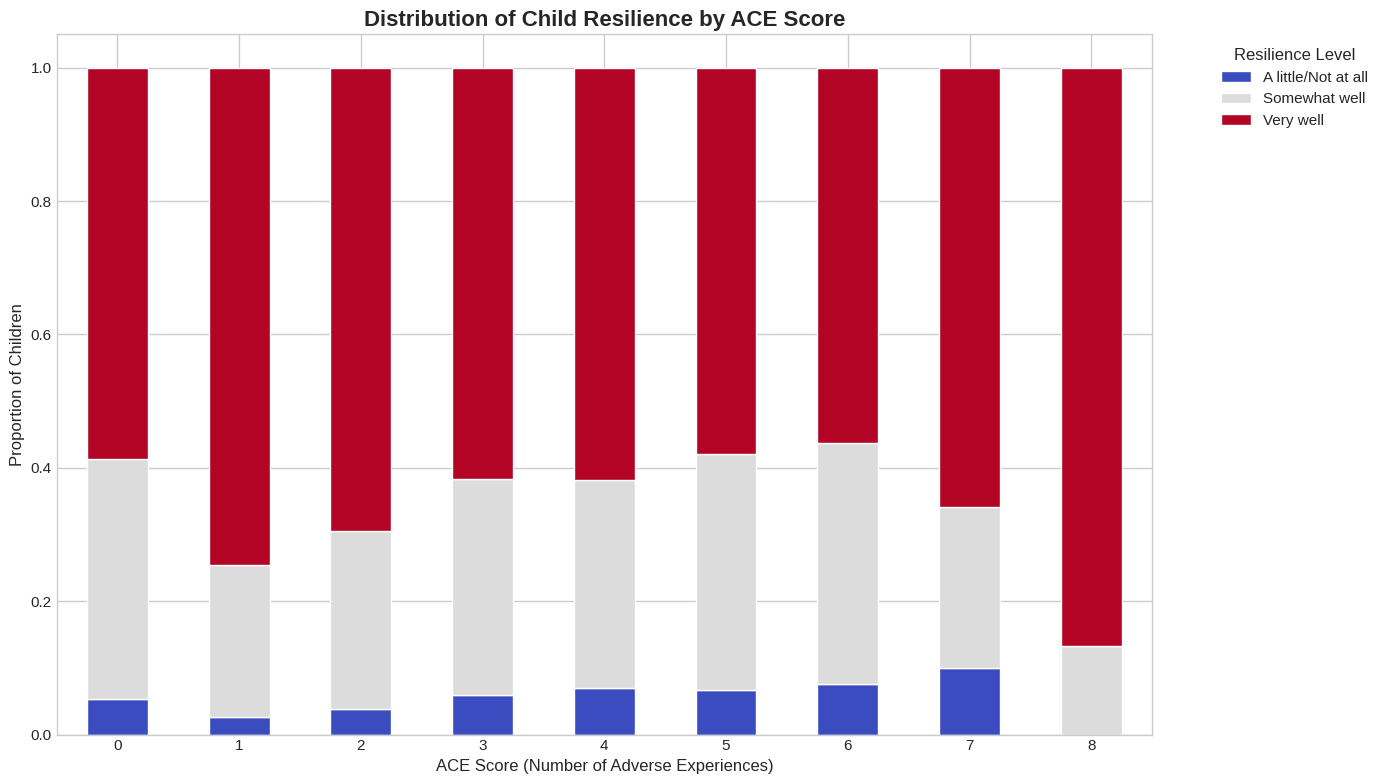

In [ ]:
# how does the reported resilience of a child change as their ACE score increases

resilience_distribution = df_subset.groupby('ace_score')['resilience_label'].value_counts(normalize=True).unstack()
resilience_distribution = resilience_distribution.fillna(0)

resilience_distribution.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='coolwarm',
    edgecolor='white'
)

plt.title('Distribution of Child Resilience by ACE Score', fontsize=16, fontweight='bold')
plt.xlabel('ACE Score (Number of Adverse Experiences)', fontsize=12)
plt.ylabel('Proportion of Children', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Resilience Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# corr: ACE Score vs. Resilience
df_resilience_test = df_subset[['ace_score', 'resilience']].dropna()

# Spearman's corr
corr_res, p_res = spearmanr(df_resilience_test['ace_score'], df_resilience_test['resilience'])

print("\n--- Analysis: ACE Score vs. Child's Resilience ---")
print(f"Spearman's Correlation Coefficient (rho): {corr_res:.4f}")
print(f"P-value: {p_res:.4f}")



--- Analysis: ACE Score vs. Child's Resilience ---
Spearman's Correlation Coefficient (rho): -0.0570
P-value: 0.0000


####2. ANALYSIS: THE BUFFERING EFFECT OF COMMUNICATION

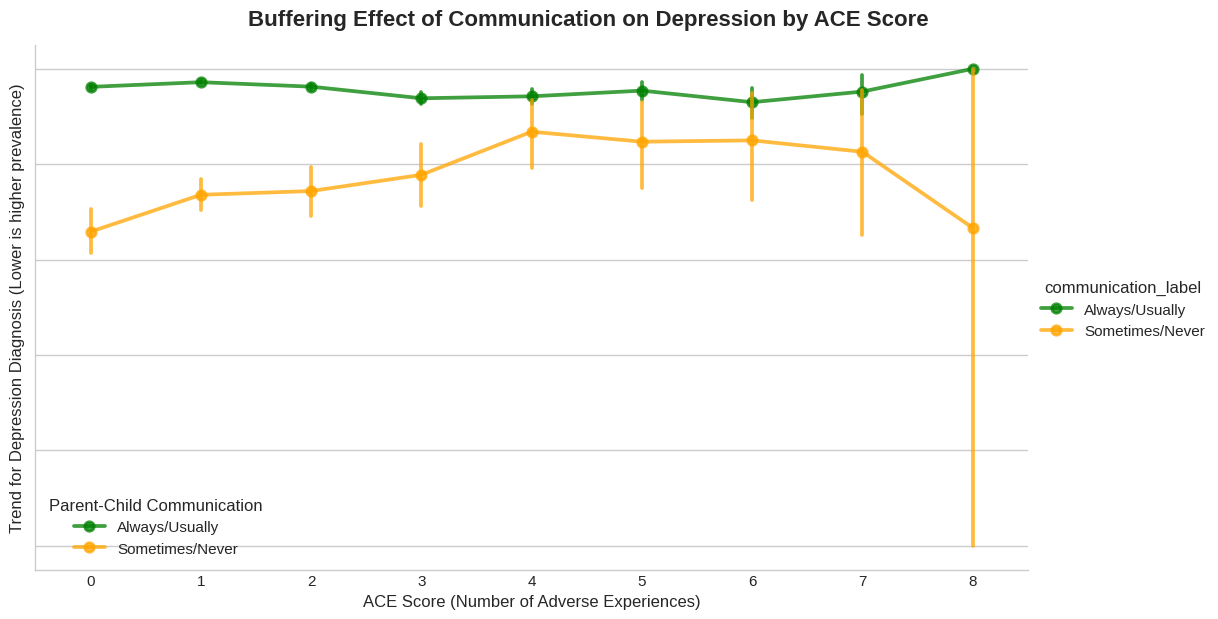

In [ ]:
# does good parent-child communication weaken the link between ACEs and depression

# group by our 'communication_label'.
# filter out 'NaN' values in communication_label for a cleaner plot.
communication_filtered_df = df_subset.dropna(subset=['communication_label'])

g = sns.catplot(
    data=communication_filtered_df,
    x='ace_score',
    y='k2q35a', # Numeric version of depression (1=Yes, 2=No)
    hue='communication_label',
    kind='point',
    palette={'Always/Usually': 'green', 'Sometimes/Never': 'orange'},
    height=6,
    aspect=1.8,
    alpha=0.75
    #legend=False
)

g.ax.set_yticklabels([])
g.ax.set_ylabel('Trend for Depression Diagnosis (Lower is higher prevalence)')
g.ax.set_xlabel('ACE Score (Number of Adverse Experiences)', fontsize=12)
g.fig.suptitle('Buffering Effect of Communication on Depression by ACE Score', y=1.03, fontsize=16, fontweight='bold')
plt.legend(title='Parent-Child Communication')

plt.show()


In [ ]:

print("\n=== Analysis: Testing the Buffering Effect of Communication ===")

df_comm_test = df_subset[['ace_score', 'communication_label', 'k2q35a']].dropna()

# create the binary depression variable on this clean data
df_comm_test['depression_binary'] = df_comm_test['k2q35a'].apply(lambda x: 1 if x == 1.0 else 0)

# Group 1: Good Communication
df_good_comm = df_comm_test[df_comm_test['communication_label'] == 'Always/Usually']
corr_good, p_good = spearmanr(df_good_comm['ace_score'], df_good_comm['depression_binary'])

print("\nGroup 1: Good Parent-Child Communication")
print(f"Spearman's Correlation (ACEs vs. Depression): {corr_good:.4f}")
print(f"P-value: {p_good:.4f}")

# Group 2: Poor Communication
df_poor_comm = df_comm_test[df_comm_test['communication_label'] == 'Sometimes/Never']
corr_poor, p_poor = spearmanr(df_poor_comm['ace_score'], df_poor_comm['depression_binary'])

print("\nGroup 2: Poor Parent-Child Communication")
print(f"Spearman's Correlation (ACEs vs. Depression): {corr_poor:.4f}")
print(f"P-value: {p_poor:.4f}")



=== Analysis: Testing the Buffering Effect of Communication ===

Group 1: Good Parent-Child Communication
Spearman's Correlation (ACEs vs. Depression): 0.0207
P-value: 0.0003

Group 2: Poor Parent-Child Communication
Spearman's Correlation (ACEs vs. Depression): -0.1228
P-value: 0.0000


####Analysis and Conclusions
- **ACEs vs. Resilience:** The visual analysis (stacked bar chart) showed that with *higher ``ACE`` scores*, the proportion of children with *low resilience increases*. However, the statistical test (``rho = -0.0570``) revealed that the *overall monotonic trend is very weak* and close to zero, as the median resilience level remains stable for most ``ACE`` scores.

  - **Conclusion:** While the proportion of at-risk children changes, there is no strong, simple monotonic relationship between the number of ACEs and a child's rank of resilience.

- **The Buffering Effect of Communication:** This analysis yielded the most complex and insightful results. The initial *visual analysis suggested a simple buffering effect*. However, the *statistical tests revealed a more nuanced reality*.

  - Good Communication Group: A very weak, but significant, positive correlation was found between ACEs and depression (``rho = 0.0207``).

  - Poor Communication Group: A weak, but significant, negative correlation was found (``rho = -0.1227``). This was counter-intuitive but correctly reflected the noisy, non-linear trend seen in the diagnostic plot.

  - **Conclusion:** The simple buffering hypothesis is **refuted**. Instead, we found that the very nature of the relationship between stress and depression is different for the two groups. For children with good communication, the link is weak and linear. For children with poor communication, the link is complex, non-linear, and cannot be described as a simple positive trend. This is a critical finding that warrants further investigation.

---

#**Part 2:** Merges aggregated NSCH data with ACS state-level data to investigate how the surrounding socio-economic environment is associated with children's well-being.

- **Study 2.1: Economy and Mental Health.**
  - Question: How do state economic indicators (poverty rate, unemployment from ``ACS``) correlate with the prevalence of depression and anxiety in children (from ``NSCH``)?

| **Variable Name** | **Description** | **Source** |
|-------------------|-----------------|------------|
| **DP03_0119PE**    | **Poverty Rate:** Percent of people of all ages in poverty. | ACS |
| **DP03_0062E**     | **Median Income:** Median household income in the past 12 months. | ACS |
| **K2Q34A**         | Aggregated to the state level to calculate the percentage of children with behavioral problems. | NSCH |


- **Study 2.2: Education and Safety.**
  - Question: Is the overall level of adult education in a state (from ``ACS``) related to how safe parents perceive their neighborhood to be (from ``NSCH``)?

| **Variable Name** | **Description** | **Source** |
|-------------------|-----------------|------------|
| **DP02_0068PE**       | **Education Level:** Percent of population 25 years and over with a bachelor's degree or higher. | ACS |
| **K11Q60**          | **Neighborhood Safety:** "Overall, you feel that this child is safe in your neighborhood." Aggregated to calculate the percentage of parents who feel 'Always' safe. | NSCH |

- **Study 2.3: Housing Conditions and Emotional Well-Being.**
  - Question: Is there a non-obvious relationship between the percentage of the population renting (from ``ACS``) and measures of children’s emotional well-being (from ``NSCH``)?

| **Variable Name** | **Description** | **Source** |
|-------------------|-----------------|------------|
| **DP04_0046PE**       | **Housing Tenure:** Percent of occupied housing units that are renter-occupied. | ACS |
| **K2Q35A**          | Aggregated to the state level to calculate the percentage of children with depression. | NSCH |

---

##Research Question 2.1: Economy and Behavioral Problems

- **Hypothesis:** States with poorer economic indicators (*higher poverty* rates) will have a higher prevalence of behavioral problems in children.

- Variables Used:

  - ACS: ``poverty_rate_pct`` (``DP03_0119PE``).

  - NSCH (Aggregated): ``behavior_prob_pct``

GOAL of this part:
1. Fetch state-level socio-economic data from the American Community Survey (ACS) using the Census Bureau's API.
2. Clean and prepare this data for merging with our NSCH dataset.

In [ ]:
# define the variables we want from the ACS Data Profile tables.
# DP03_0119PE: Percent of people of all ages in poverty.
# DP03_0062E:  Median household income.
# NAME:        The name of the state.
ACS_VARIABLES = "NAME,DP03_0119PE,DP03_0062E"

API_URL = f"https://api.census.gov/data/2023/acs/acs5/profile?get={ACS_VARIABLES}&for=state:*&key={API_KEY}"


####2. MAKE THE API CALL

In [ ]:
df_acs = None
if API_KEY:
    print(f"\nRequesting data from: {API_URL}")
    response = requests.get(API_URL)
    response.raise_for_status()

    data = response.json()

    df_acs = pd.DataFrame(data[1:], columns=data[0])

    display(df_acs.head())



Requesting data from: https://api.census.gov/data/2023/acs/acs5/profile?get=NAME,DP03_0119PE,DP03_0062E&for=state:*&key=a6c74e3cb42fbc8336d902f2d8e247d668d49dbe


,NAME,DP03_0119PE,DP03_0062E,state
0,Alabama,11.3,62027,01
1,Alaska,6.8,89336,02
2,Arizona,8.9,76872,04
3,Arkansas,11.5,58773,05
4,California,8.4,96334,06


####3. CLEAN AND PREPARE ACS DATA

In [ ]:
rename_map = {
    'DP03_0119PE': 'poverty_rate_pct',
    'DP03_0062E': 'median_income',
    'state': 'fipsst' # Rename 'state' to 'fipsst' to match our NSCH data
}
df_acs.rename(columns=rename_map, inplace=True)

numeric_cols = ['poverty_rate_pct', 'median_income']
for col in numeric_cols:
    df_acs[col] = pd.to_numeric(df_acs[col], errors='coerce')

print("\n=== Head of Cleaned ACS DataFrame ===")
print(df_acs.head())

print("\n=== Info of Cleaned ACS DataFrame ===")
df_acs.info()



=== Head of Cleaned ACS DataFrame ===
         NAME  poverty_rate_pct  median_income fipsst
0     Alabama              11.3          62027     01
1      Alaska               6.8          89336     02
2     Arizona               8.9          76872     04
3    Arkansas              11.5          58773     05
4  California               8.4          96334     06

=== Info of Cleaned ACS DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NAME              52 non-null     object 
 1   poverty_rate_pct  52 non-null     float64
 2   median_income     52 non-null     int64  
 3   fipsst            52 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.8+ KB


###MERGING, AGGREGATING, AND ANALYZING MACRO-LEVEL DATA

GOAL of this part:
1. Aggregate the NSCH data to the state level.
2. Merge the aggregated NSCH data with the state-level ACS data.
3. Visualize and analyze the relationship between state-level economic indicators and children's mental health outcomes.


####1. AGGREGATE NSCH DATA TO STATE LEVEL

In [ ]:
# calculate the prevalence of behavioral problems for each state.

# create a numeric 'behavior_yes' column (1 for Yes, 0 for No/NaN)
df_subset['behavior_yes'] = df_subset['behavior_label'].apply(lambda x: 1 if x == 'Yes' else 0)

state_health_metrics = df_subset.groupby('fipsst').agg(
    behavior_prob_pct=('behavior_yes', 'mean')
).reset_index()

state_health_metrics['behavior_prob_pct'] = state_health_metrics['behavior_prob_pct'] * 100

print("\nNSCH data aggregated to the state level.")
display(state_health_metrics.head())



NSCH data aggregated to the state level.


,fipsst,behavior_prob_pct
0,01,10.082063
1,02,9.068627
2,04,6.483791
3,05,10.785463
4,06,7.282794


####2. MERGE NSCH AND ACS DATA

In [ ]:
# merge our aggregated health data with the ACS economic data

# ensure the 'fipsst' column in df_acs is of the same type as in state_health_metrics
df_acs['fipsst'] = df_acs['fipsst'].astype(str)
state_health_metrics['fipsst'] = state_health_metrics['fipsst'].astype(str)

# left merge to keep all states from our health data
df_merged = pd.merge(state_health_metrics, df_acs, on='fipsst', how='left')

display(df_merged.head())

,fipsst,behavior_prob_pct,NAME,poverty_rate_pct,median_income
0,01,10.082063,Alabama,11.3,62027
1,02,9.068627,Alaska,6.8,89336
2,04,6.483791,Arizona,8.9,76872
3,05,10.785463,Arkansas,11.5,58773
4,06,7.282794,California,8.4,96334


####3. VISUALIZE MACRO-LEVEL RELATIONSHIP

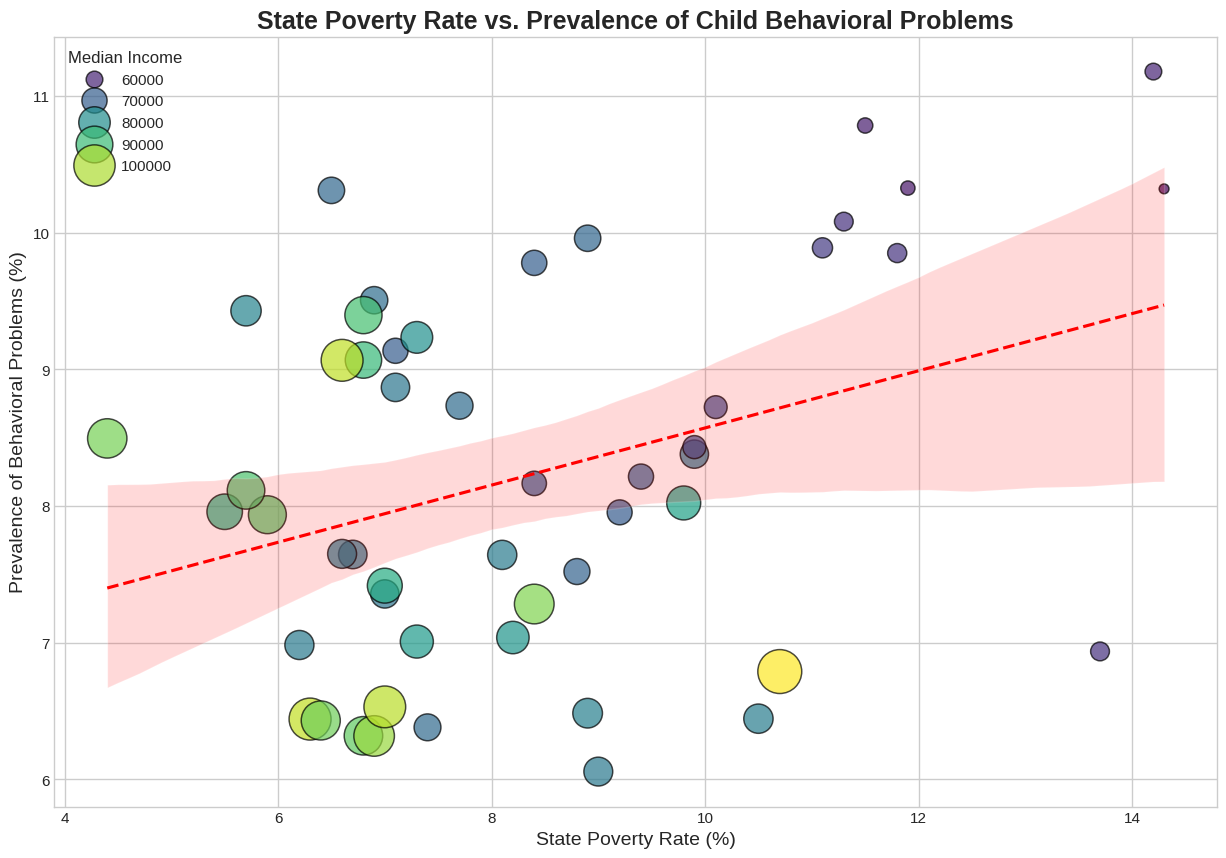

In [ ]:

plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=df_merged,
    x='poverty_rate_pct',
    y='behavior_prob_pct',
    size='median_income',
    hue='median_income',
    palette='viridis',
    sizes=(50, 1000),
    alpha=0.7,
    edgecolor='black'
)

# regression line to better see the trend
sns.regplot(
    data=df_merged,
    x='poverty_rate_pct',
    y='behavior_prob_pct',
    scatter=False,
    color='red',
    line_kws={'linestyle':'--'}
)


plt.title('State Poverty Rate vs. Prevalence of Child Behavioral Problems', fontsize=18, fontweight='bold')
plt.xlabel('State Poverty Rate (%)', fontsize=14)
plt.ylabel('Prevalence of Behavioral Problems (%)', fontsize=14)
plt.grid(True)
plt.legend(title='Median Income', loc='upper left')

# for i, row in df_merged.head(5).iterrows():
#     plt.text(row['poverty_rate_pct'], row['behavior_prob_pct'] + 0.1, row['NAME'], fontsize=9)

plt.show()


In [ ]:
df_macro_corr = df_merged.dropna(subset=['poverty_rate_pct', 'behavior_prob_pct'])


# Pearson's Corr
corr_p, p_p = pearsonr(df_macro_corr['poverty_rate_pct'], df_macro_corr['behavior_prob_pct'])

print("\n=== Statistical Analysis of Macro-Level Economic Data 1: Pearson's Linear Correlation ===")
print(f"Pearson's Correlation Coefficient (r): {corr_p:.4f}")
print(f"P-value: {p_p:.4f}")

# Spearman's Corr
corr_s, p_s = spearmanr(df_macro_corr['poverty_rate_pct'], df_macro_corr['behavior_prob_pct'])

print("\n=== Statistical Analysis of Macro-Level Economic Data 2: Spearman's Monotonic Correlation ===")
print(f"Spearman's Correlation Coefficient (rho): {corr_s:.4f}")
print(f"P-value: {p_s:.4f}")



=== Statistical Analysis of Macro-Level Economic Data 1: Pearson's Linear Correlation ===
Pearson's Correlation Coefficient (r): 0.3496
P-value: 0.0119

=== Statistical Analysis of Macro-Level Economic Data 2: Spearman's Monotonic Correlation ===
Spearman's Correlation Coefficient (rho): 0.2571
P-value: 0.0686


####Analysis and Conclusions
- **Visual Analysis:** The scatter plot showed a *clear positive trend*, with the regression line sloping upwards.

- **Statistical Analysis:** The results highlighted an important nuance. Pearson's test, which measures linear relationships, found a statistically significant moderate *positive correlation* (``r = 0.3496``, ``p < 0.05``). However, Spearman's test, which measures monotonic (rank-based) relationships, was *not statistically significant* (``p > 0.05``).

- **Conclusion:** There is a significant linear relationship between state poverty rates and child behavioral problems, likely driven by states at the extremes. However, the overall rank-based relationship is weaker. This suggests that while a linear trend exists, it's not a perfectly consistent monotonic increase across all states.

---

##Research Question 2.2: Education and Neighborhood Safety

- **Hypothesis:** States with a more educated adult population will have a higher perception of neighborhood safety among parents.

- Variables Used:

  - ACS: ``bachelor_degree_pct`` (``DP02_0068PE``).

  - NSCH (Aggregated): ``safety_perception_pct`` (``K11Q60``)

In [ ]:
ACS_EDU_VARIABLES = "NAME,DP03_0119PE,DP03_0062E,DP02_0068PE"

API_URL_EDU = f"https://api.census.gov/data/2023/acs/acs5/profile?get={ACS_EDU_VARIABLES}&for=state:*&key={API_KEY}"


####2. FETCH & PREPARE NEW ACS DATA

In [ ]:
df_acs_edu = None

response = requests.get(API_URL_EDU)
response.raise_for_status()
data = response.json()

df_acs_edu = pd.DataFrame(data[1:], columns=data[0])

# clean and prepare the new ACS data
rename_map_edu = {
    'DP03_0119PE': 'poverty_rate_pct',
    'DP03_0062E': 'median_income',
    'DP02_0068PE': 'bachelor_degree_pct', # new education column
    'state': 'fipsst'
}
df_acs_edu.rename(columns=rename_map_edu, inplace=True)

numeric_cols_edu = ['poverty_rate_pct', 'median_income', 'bachelor_degree_pct']
for col in numeric_cols_edu:
    df_acs_edu[col] = pd.to_numeric(df_acs_edu[col], errors='coerce')

print("New ACS data fetched and prepared successfully.")
display(df_acs_edu.head())



New ACS data fetched and prepared successfully.


,NAME,poverty_rate_pct,median_income,bachelor_degree_pct,fipsst
0,Alabama,11.3,62027,27.8,01
1,Alaska,6.8,89336,31.2,02
2,Arizona,8.9,76872,32.6,04
3,Arkansas,11.5,58773,25.1,05
4,California,8.4,96334,36.5,06


####3. AGGREGATE NSCH SAFETY DATA

In [ ]:

df_subset['k11q60'] = df['K11Q60']

# K11Q60: "I feel my child is safe in our neighborhood"
# coding: 1=Always, 2=Sometimes, 3=Never
# create a binary variable: 1 if parent feels 'Always' safe, 0 otherwise.
df_subset['neighborhood_safe'] = df_subset['k11q60'].apply(lambda x: 1 if x == 1.0 else 0)

# aggregate this and the previous behavior metric by state
state_metrics_updated = df_subset.groupby('fipsst').agg(
    behavior_prob_pct=('behavior_yes', 'mean'),
    safety_perception_pct=('neighborhood_safe', 'mean')
).reset_index()

state_metrics_updated['behavior_prob_pct'] *= 100
state_metrics_updated['safety_perception_pct'] *= 100

print("\nNSCH data aggregated for safety perception.")
display(state_metrics_updated.head())



NSCH data aggregated for safety perception.


,fipsst,behavior_prob_pct,safety_perception_pct
0,01,10.082063,2.461899
1,02,9.068627,2.573529
2,04,6.483791,2.493766
3,05,10.785463,1.758499
4,06,7.282794,5.685690


####4. MERGE & VISUALIZE

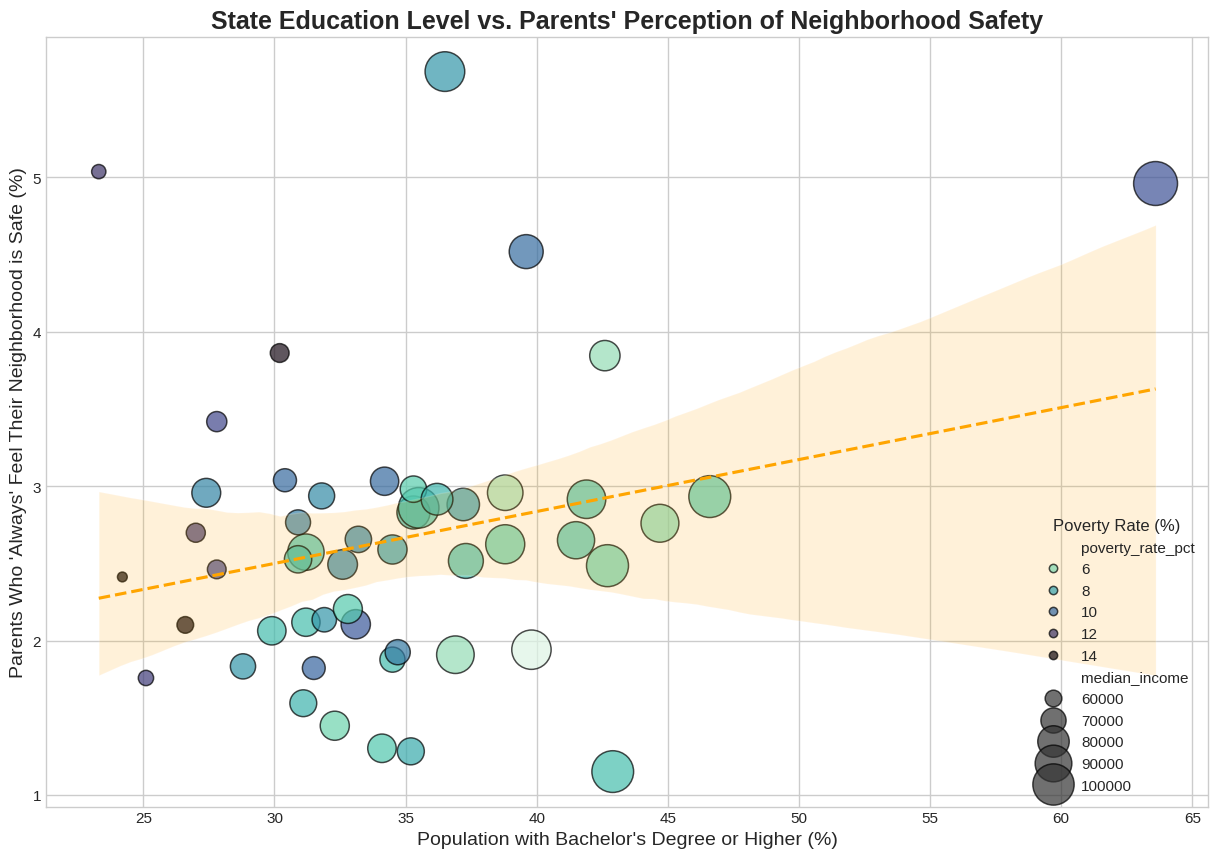

In [ ]:
# merge the new aggregated metrics with the new ACS data
df_merged_edu = pd.merge(state_metrics_updated, df_acs_edu, on='fipsst', how='left')

# create the scatter plot for Education vs. Safety
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=df_merged_edu,
    x='bachelor_degree_pct',
    y='safety_perception_pct',
    size='median_income',
    hue='poverty_rate_pct',
    palette='mako_r',
    sizes=(50, 1000),
    alpha=0.7,
    edgecolor='black'
)

sns.regplot(
    data=df_merged_edu,
    x='bachelor_degree_pct',
    y='safety_perception_pct',
    scatter=False,
    color='orange',
    line_kws={'linestyle':'--'}
)

plt.title("State Education Level vs. Parents' Perception of Neighborhood Safety", fontsize=18, fontweight='bold')
plt.xlabel("Population with Bachelor's Degree or Higher (%)", fontsize=14)
plt.ylabel("Parents Who 'Always' Feel Their Neighborhood is Safe (%)", fontsize=14)
plt.grid(True)
plt.legend(title='Poverty Rate (%)', loc='lower right')

plt.show()


In [ ]:
print("--- Starting Part 9.5: Statistical Analysis of Macro-Level Education Data ---")

df_edu_corr = df_merged_edu.dropna(subset=['bachelor_degree_pct', 'safety_perception_pct'])


# Pearson's Corr
corr_p_edu, p_p_edu = pearsonr(df_edu_corr['bachelor_degree_pct'], df_edu_corr['safety_perception_pct'])

print("\n--- Analysis 1: Pearson's Linear Correlation ---")
print(f"Pearson's Correlation Coefficient (r): {corr_p_edu:.4f}")
print(f"P-value: {p_p_edu:.4f}")

# Spearman's Corr
corr_s_edu, p_s_edu = spearmanr(df_edu_corr['bachelor_degree_pct'], df_edu_corr['safety_perception_pct'])

print("\n--- Analysis 2: Spearman's Monotonic Correlation ---")
print(f"Spearman's Correlation Coefficient (rho): {corr_s_edu:.4f}")
print(f"P-value: {p_s_edu:.4f}")

print("\n\nStatistical analysis of macro-level education factors complete.")


--- Starting Part 9.5: Statistical Analysis of Macro-Level Education Data ---

--- Analysis 1: Pearson's Linear Correlation ---
Pearson's Correlation Coefficient (r): 0.2456
P-value: 0.0824

--- Analysis 2: Spearman's Monotonic Correlation ---
Spearman's Correlation Coefficient (rho): 0.1588
P-value: 0.2658


Statistical analysis of macro-level education factors complete.


####Analysis and Conclusions
- **Visual Analysis:** The scatter plot showed a *slight positive trend*.

- **Statistical Analysis:** Both Pearson's and Spearman's correlation tests returned *high p-values* (``p > 0.05``).

- **Conclusion:** The hypothesis is **refuted**. Despite a slight visual trend, there is *no statistically significant evidence* of a relationship between the education level of a state and parents' perception of safety.

---

##Research Question 2.3: Housing and Depression

- **Hypothesis:** States with a higher percentage of renter-occupied housing will have a higher prevalence of child depression.

- Variables Used:

  - ACS: ``renter_occupied_pct`` (``DP04_0046PE``).

  - NSCH (Aggregated): ``depression_pct``.

GOAL of this part:
1. Fetch state-level housing data (renter vs. owner occupied) from ACS.
2. Aggregate the prevalence of child depression from NSCH by state.
3. Merge the datasets and visualize the relationship to test our final hypothesis.

In [ ]:
ACS_HOUSING_VARIABLES = "NAME,DP04_0046PE"

API_URL_HOUSING = f"https://api.census.gov/data/2023/acs/acs5/profile?get={ACS_HOUSING_VARIABLES}&for=state:*&key={API_KEY}"


####2. FETCH & PREPARE NEW ACS HOUSING DATA

In [ ]:
df_acs_housing = None

response = requests.get(API_URL_HOUSING)
response.raise_for_status()
data = response.json()

df_acs_housing = pd.DataFrame(data[1:], columns=data[0])

# clean and prepare the new ACS data
rename_map_housing = {
    'DP04_0046PE': 'renter_occupied_pct', # new housing column
    'state': 'fipsst'
}
df_acs_housing.rename(columns=rename_map_housing, inplace=True)

df_acs_housing['renter_occupied_pct'] = pd.to_numeric(df_acs_housing['renter_occupied_pct'], errors='coerce')

print("ACS housing data fetched and prepared successfully.")
display(df_acs_housing.head())



ACS housing data fetched and prepared successfully.


,NAME,renter_occupied_pct,fipsst
0,Alabama,69.9,01
1,Alaska,66.6,02
2,Arizona,67.0,04
3,Arkansas,66.1,05
4,California,55.8,06


####3. AGGREGATE NSCH DEPRESSION DATA

In [ ]:
# create a numeric 'depression_yes' column (1 for Yes, 0 for No/NaN)
df_subset['depression_yes'] = df_subset['depression_label'].apply(lambda x: 1 if x == 'Yes' else 0)

# agg depression prevalence by state
state_depression_metrics = df_subset.groupby('fipsst').agg(
    depression_pct=('depression_yes', 'mean')
).reset_index()

state_depression_metrics['depression_pct'] *= 100

print("\nNSCH data aggregated for depression prevalence.")
display(state_depression_metrics.head())



NSCH data aggregated for depression prevalence.


,fipsst,depression_pct
0,01,4.689332
1,02,3.431373
2,04,3.865337
3,05,4.572098
4,06,4.088586


####4. MERGE & VISUALIZE

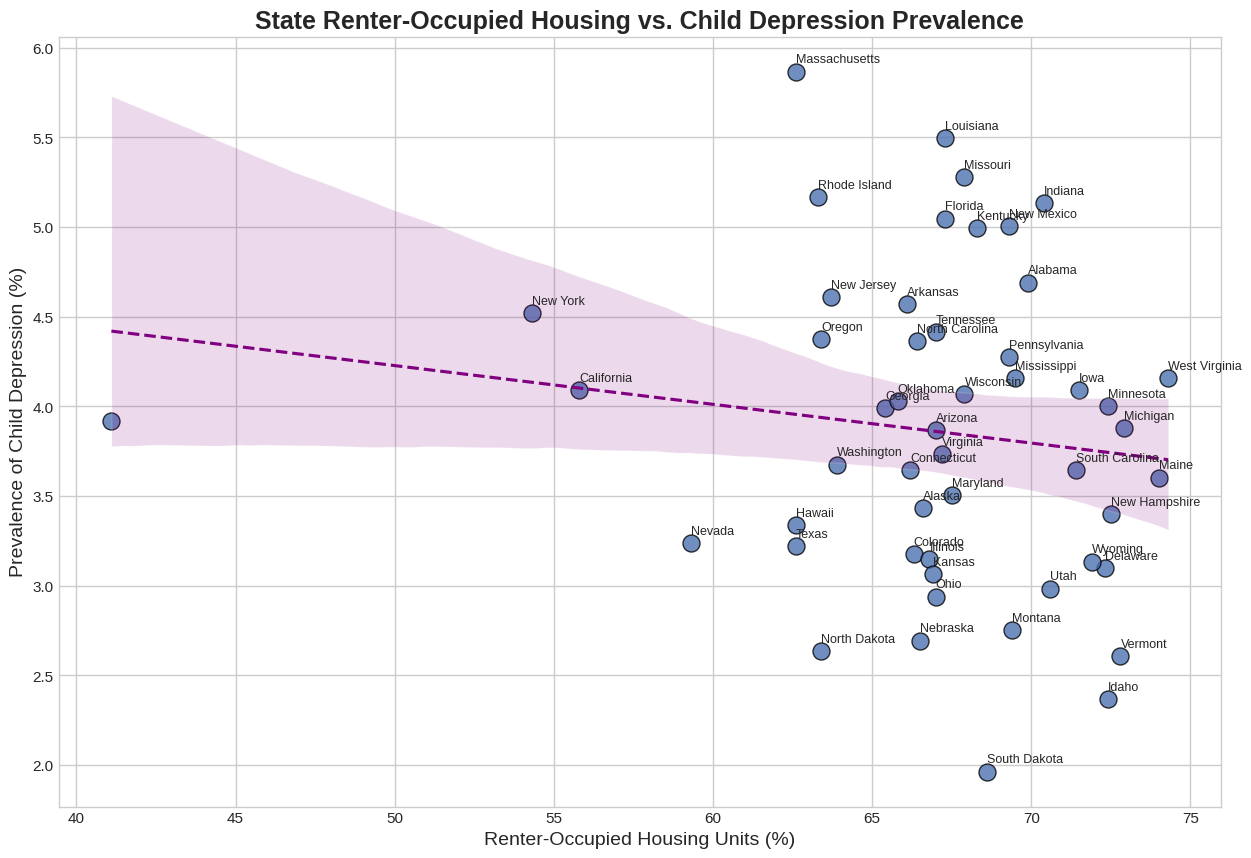

In [ ]:
df_merged_housing = pd.merge(state_depression_metrics, df_acs_housing, on='fipsst', how='left')

# create the scatter plot for Renter Percentage vs. Depression
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=df_merged_housing,
    x='renter_occupied_pct',
    y='depression_pct',
    alpha=0.8,
    edgecolor='black',
    s=150)

sns.regplot(
    data=df_merged_housing,
    x='renter_occupied_pct',
    y='depression_pct',
    scatter=False,
    color='purple',
    line_kws={'linestyle':'--'}
)

plt.title("State Renter-Occupied Housing vs. Child Depression Prevalence", fontsize=18, fontweight='bold')
plt.xlabel("Renter-Occupied Housing Units (%)", fontsize=14)
plt.ylabel("Prevalence of Child Depression (%)", fontsize=14)
plt.grid(True)

# label a few states for context
for i, row in df_merged_housing.iterrows():
    # label states with high renter percentage or high depress
    if row['renter_occupied_pct'] > 45 or row['depression_pct'] > 6:
          plt.text(row['renter_occupied_pct'], row['depression_pct'] + 0.05, row['NAME'], fontsize=9)

plt.show()

In [ ]:

df_housing_corr = df_merged_housing.dropna(subset=['renter_occupied_pct', 'depression_pct'])


# Pearson's Corr
corr_p_hous, p_p_hous = pearsonr(df_housing_corr['renter_occupied_pct'], df_housing_corr['depression_pct'])

print("\n=== Statistical Analysis of Macro-Level Housing Data 1: Pearson's Linear Correlation ===")
print(f"Pearson's Correlation Coefficient (r): {corr_p_hous:.4f}")
print(f"P-value: {p_p_hous:.4f}")

# Spearman's Corr
corr_s_hous, p_s_hous = spearmanr(df_housing_corr['renter_occupied_pct'], df_housing_corr['depression_pct'])

print("\n=== Statistical Analysis of Macro-Level Housing Data 2: Spearman's Monotonic Correlation ===")
print(f"Spearman's Correlation Coefficient (rho): {corr_s_hous:.4f}")
print(f"P-value: {p_s_hous:.4f}")



=== Statistical Analysis of Macro-Level Housing Data 1: Pearson's Linear Correlation ===
Pearson's Correlation Coefficient (r): -0.1396
P-value: 0.3287

=== Statistical Analysis of Macro-Level Housing Data 2: Spearman's Monotonic Correlation ===
Spearman's Correlation Coefficient (rho): -0.1457
P-value: 0.3075


####Analysis and Conclusions
- **Visual Analysis:** The scatter plot showed a *slight, counter-intuitive negative trend.*

- **Statistical Analysis:** Both Pearson's and Spearman's correlation tests returned *high p-values* (``p > 0.05``).

- **Conclusion:** The hypothesis is **refuted**. There is *no statistically significant evidence* of a relationship between the percentage of renters in a state and the prevalence of child depression. The slight negative trend observed visually is likely due to random chance.


---

#General Conclusion & Future Work

This project successfully demonstrated the multi-faceted nature of children's mental health. The analysis revealed that while individual adverse experiences are powerful predictors of negative outcomes, their impact is mediated by both family-level protective factors and state-level socio-economic conditions.

- Key Findings Summary:

1. A strong, statistically significant link exists between ACEs and behavioral problems.

2. The relationship between ACEs and depression is more complex and appears to be fundamentally different depending on the quality of parent-child communication, refuting a simple "buffering" hypothesis.

3. A significant linear relationship exists between state poverty levels and the prevalence of child behavioral problems.

4. No statistically significant evidence was found to support a link between a state's education level and perceived safety, or between housing tenure and child depression, highlighting the importance of statistical validation over visual intuition.

- Limitations & Suggestions for Future Research:

  - Correlation vs. Causation: This analysis identifies strong associations but cannot prove causality.

  - Advanced Modeling: Future work could employ regression models to control for multiple variables simultaneously and quantify the impact of each factor more precisely.

  - Geographic Granularity: Repeating the macro-level analysis at a county level could uncover more localized trends.

This project serves as a robust foundation, demonstrating a full cycle of data analysis from data acquisition and cleaning to hypothesis testing and nuanced interpretation.

---